In [6]:
import tidy3d as td

# size of simulation domain
Lx, Ly, Lz = 2, 2, 2
# Lx, Ly, Lz = 2,3,2
dl = 0.06667

# waveguide information
wg_permittivity = 3.477 ** 2

# automatic grid specification
# grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wvl_um)
grid_spec = td.GridSpec.uniform(dl=dl)
# mesh = td.TriangleMesh.from_stl("./models/unit_cube.stl")
# mesh = td.TriangleMesh.from_stl("./models/busted.stl")
mesh = td.TriangleMesh.from_stl("./wg.stl", scale=1)

tmesh = mesh.trimesh
# tmesh.rezero()
# tmesh.apply_translation(-tmesh.centroid)

bmesh = tmesh.bounding_box
bmesh.visual.face_colors = [115, 112, 255, 100]
print("center:", mesh.bounding_box.center)
print("size:", mesh.bounding_box.size)

# (tmesh).show(viewer='gl')

geometry = mesh

# geometry = td.Box(center=(0, 0, 0), size=(1,1,1))

center: (0.0, 0.0, -1.4901199999611814e-07)
size: (0.499999940396, 0.40000000596, 0.22000046074399998)


<Axes: title={'center': 'cross section at y=0.00'}, xlabel='x', ylabel='z'>

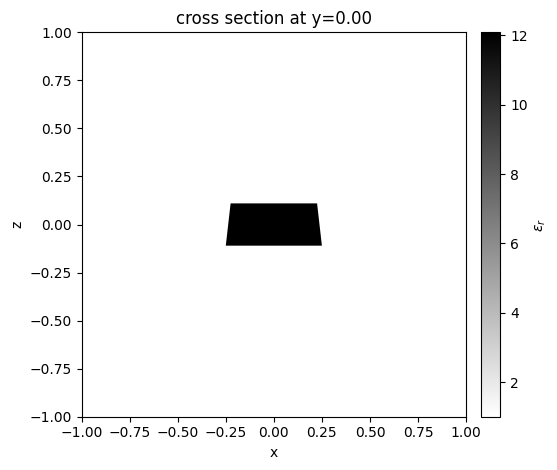

In [7]:

waveguide = td.Structure(
    geometry=geometry,
    medium=td.Medium(permittivity=wg_permittivity),
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_spec=grid_spec,
    structures=[waveguide],
    run_time=1e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
)

sim.plot_eps(y=0)

use sim to generate spatial medium

In [10]:
import custom.spatial_medium as sm
creator = sm.SpatialMediumCreator2(sim)

medium, cell_permittivity = creator.create()
# waveguide.medium = medium

--total cells 27000
Calc Time elapsed: 301.25851060000423
Average Time elapsed: 12.637659100000747


visualize the medium

In [1]:
import numpy as np
import matplotlib.pyplot as plt  

permittivity: td.SpatialDataArray = medium.permittivity # type: ignore

if True:
	X,Y,Z = np.meshgrid(permittivity.x, permittivity.y, permittivity.z, indexing='ij')
	fig = plt.figure(figsize=(8, 7))
	ax = fig.add_subplot(111, projection='3d')
	X_1 = X.flatten()
	Y_1 = Y.flatten()
	Z_1 = Z.flatten()
	E_1 = permittivity.values.flatten()
	scatter = ax.scatter(X_1, Y_1, Z_1, s=E_1*12, c=E_1, cmap='viridis', marker='o')
	cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
	cbar.set_label('Permittivity')
	ax.set_xlabel('X')
	ax.set_ylabel('Y')
	ax.set_zlabel('Z')
	plt.show()

import vedo
vedo.settings.default_backend = 'vtk'
sim_box = vedo.Box(
	pos=sim.bounding_box.center,
	size=sim.size,
	c='g2',
	alpha=0.1
)
plotter = vedo.Plotter()

if True:
	x_bounds = [float(permittivity.x.min()), float(permittivity.x.max())]
	y_bounds = [float(permittivity.y.min()), float(permittivity.y.max())]
	z_bounds = [float(permittivity.z.min()), float(permittivity.z.max())]

	X_2, Y_2 = np.meshgrid(permittivity.x, permittivity.y)
	start_pts = np.array([X_2.flatten(), Y_2.flatten(), np.ones_like(X_2.flatten()) * z_bounds[0]]).T
	end_pts = np.array([X_2.flatten(), Y_2.flatten(), np.ones_like(X_2.flatten()) * z_bounds[1]]).T

	Y_2, Z_2 = np.meshgrid(permittivity.y, permittivity.z)
	start_pts = np.vstack([start_pts, np.array([np.ones_like(Y_2.flatten()) * x_bounds[0], Y_2.flatten(), Z_2.flatten()]).T])
	end_pts = np.vstack([end_pts, np.array([np.ones_like(Y_2.flatten()) * x_bounds[1], Y_2.flatten(), Z_2.flatten()]).T])

	X_2, Z_2 = np.meshgrid(permittivity.x, permittivity.z)
	start_pts = np.vstack([start_pts, np.array([X_2.flatten(), np.ones_like(Z_2.flatten()) * y_bounds[0], Z_2.flatten()]).T])
	end_pts = np.vstack([end_pts, np.array([X_2.flatten(), np.ones_like(Z_2.flatten()) * y_bounds[1], Z_2.flatten()]).T])

	lines = vedo.Lines(start_pts, end_pts, c='k')

	plotter.add(lines)

original_shape = cell_permittivity.shape
new_shape = (original_shape[0] + 2, original_shape[1] + 2, original_shape[2] + 2)
cell_permittivity[cell_permittivity <= 1.0] = 0
new_data_matrix = np.zeros(new_shape, dtype=np.uint8)
new_data_matrix[1:-1, 1:-1, 1:-1] = cell_permittivity

vol1 = vedo.Volume(new_data_matrix, spacing=(dl, dl, dl), origin=(-(Lx+dl)/2, -(Ly+dl)/2, -(Lz+dl)/2))
vol1.cmap(['white','b','r']).mode(1).off()
plotter.add(vol1)


vol2 = vedo.Volume(permittivity.values, spacing=(dl, dl, dl), origin=(-(Lx)/2, -(Ly)/2, -(Lz)/2))
vol2.cmap(['white','b', 'r']).mode(1)
plotter.add(vol2)

plotter.add(sim_box)
structures = vedo.Mesh([tmesh.vertices, tmesh.faces])
structures.c('y').alpha(0.4)
plotter.add(structures)

def buttonfunc(obj, ename):
	structures.toggle()
	obj.switch()

plotter.add_button(
    buttonfunc,
    pos=(0.9, 0.1),   # x,y fraction from bottom left corner
    states=["hide s", "show s"],  # text for each state
    c=["w", "r"],     # font color for each state
    bc=["dg", "dv"],  # background color for each state
    size=30,          # font size
    bold=True,        # bold font
    italic=False,     # non-italic font style
)
def buttonfunc2(obj, ename):
	vol1.toggle()
	vol2.toggle()
	obj.switch()


def buttonfunc3(obj, ename):
	lines.toggle()

plotter.add_button(
    buttonfunc2,
    pos=(0.9, 0.2),   # x,y fraction from bottom left corner
    states=["coords", "cell"],  # text for each state
    c=["w", "r"],     # font color for each state
    size=30,          # font size
    bold=True,        # bold font
    italic=False,     # non-italic font style
)

plotter.add_button(
    buttonfunc3,
    pos=(0.9, 0.3),   # x,y fraction from bottom left corner
    states=["lines"],  # text for each state
    c=["g", "r"],     # font color for each state
    size=30,          # font size
    bold=True,        # bold font
    italic=False,     # non-italic font style
)

plotter.show(viewup='z', axes=1).close()

NameError: name 'medium' is not defined

In [5]:
plane = td.Box(center=(0, 0, 0), size=(4, 0, 3.5))
mode_spec = td.ModeSpec(
    num_modes=3,
    target_neff=2.0,
)
from tidy3d.constants import C_0
from tidy3d.plugins.mode.mode_solver import ModeSolver
# central frequency
wvl_um = 1.55
freq0 = C_0 / wvl_um
fwidth = freq0 / 3
num_freqs = 11
f0_ind = num_freqs // 2
freqs = np.linspace(freq0 - fwidth / 2, freq0 + fwidth / 2, num_freqs)

waveguide = td.Structure(
    geometry=geometry,
    medium=medium,
)

sim = td.Simulation(
    size=(Lx, Ly, Lz),
    grid_spec=grid_spec,
    structures=[waveguide],
    run_time=1e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
    medium=td.Medium(permittivity=1.444**2),
)

mode_solver = ModeSolver(
    simulation=sim,
    plane=plane,
    mode_spec=mode_spec,
    freqs=freqs,
)
mode_data = mode_solver.solve()


17:02:34 中国标准时间 WARNING: Use the remote mode solver with subpixel         
                      averaging for better accuracy through                     
                      'tidy3d.plugins.mode.web.run(...)'.                       

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

17:02:35 中国标准时间 WARNING: Client-side permittivity of a 'TriangleMesh' may 
                      be inaccurate if the mesh is not unionized. We recommend  
                      unionizing all meshes before import. A                    
                      'PermittivityMonitor' can be used to obtain the true      
                      permittivity and check that the surface mesh is loaded    
                      correctly.                                                

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

17:02:36 中国标准时间 WARNING: Client-side permittivity of a 'TriangleMesh' may 
                      be inaccurate if the mesh is not unionized. We recommend  
                      unionizing all meshes before import. A                    
                      'PermittivityMonitor' can be used to obtain the true      
                      permittivity and check that the surface mesh is loaded    
                      correctly.                                                

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Client-side permittivity of a 'TriangleMesh' may be    
                inaccurate if the mesh is not unionized. We recommend unionizing
                all meshes before import. A 'PermittivityMonitor' can be used to
                obtain the true permittivity and check that the surface mesh is 
                loaded correctly.                                               

                WARNING: Mode field at frequency index 0, mode index 1 does not 
                decay at the plane boundaries.                                  

                WARNING: Mode field at frequency index 0, mode index 2 does not 
                decay at the plane boundaries.                                  

                WARNING: Mode field at frequency index 1, mode index 1 does not 
                decay at the plane boundaries.                                  

                WARNING: Mode field at frequency index 1, mode index 2 does not 
                decay at the plane boundaries.                                  

                WARNING: Mode field at frequency index 2, mode index 2 does not 
                decay at the plane boundaries.                                  

                WARNING: Mode field at frequency index 3, mode index 2 does not 
                decay at the plane boundaries.                                  

                WARNING: Mode field at frequency index 4, mode index 2 does not 
                decay at the plane boundaries.                                  

                WARNING: Mode field at frequency index 5, mode index 2 does not 
                decay at the plane boundaries.                                  

                WARNING: Mode field at frequency index 6, mode index 2 does not 
                decay at the plane boundaries.                                  

                WARNING: Mode field at frequency index 7, mode index 2 does not 
                decay at the plane boundaries.                                  

                WARNING: Mode field at frequency index 8, mode index 2 does not 
                decay at the plane boundaries.                                  

<xarray.ModeIndexDataArray (f: 11, mode_index: 3)> Size: 132B
array([[1.7809888, 1.48894  , 1.3810811],
       [1.8497475, 1.5085359, 1.3921566],
       [1.918651 , 1.5306381, 1.4030439],
       [1.9861104, 1.5557764, 1.4140902],
       [2.0510836, 1.5843756, 1.4256957],
       [2.1129723, 1.6167053, 1.4383464],
       [2.1714966, 1.65284  , 1.4526231],
       [2.2265885, 1.6926587, 1.469217 ],
       [2.2783115, 1.735846 , 1.4888933],
       [2.326805 , 1.7819192, 1.5124137],
       [2.37225  , 1.8302656, 1.5404406]], dtype=float32)
Coordinates:
  * f           (f) float64 88B 1.612e+14 1.676e+14 ... 2.192e+14 2.257e+14
  * mode_index  (mode_index) int32 12B 0 1 2
Attributes:
    long_name:  Propagation index


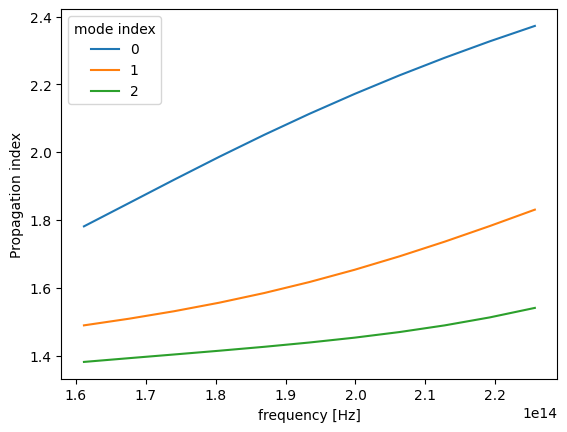

In [6]:
fig, ax = plt.subplots(1)
n_eff = mode_data.n_eff  # real part of the effective mode index
n_eff.plot.line(x="f")
plt.show()


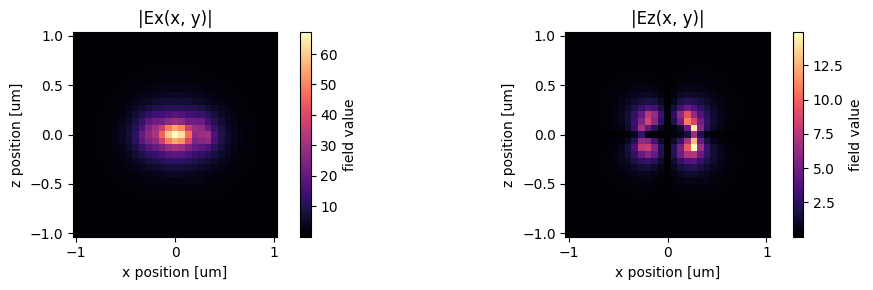

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=0, f=f0_ind)).plot(x="x", y="z", ax=ax1, cmap="magma")
abs(mode_data.Ez.isel(mode_index=0, f=f0_ind)).plot(x="x", y="z", ax=ax2, cmap="magma")

ax1.set_title("|Ex(x, y)|")
ax1.set_aspect("equal")
ax2.set_title("|Ez(x, y)|")
ax2.set_aspect("equal")
plt.show()


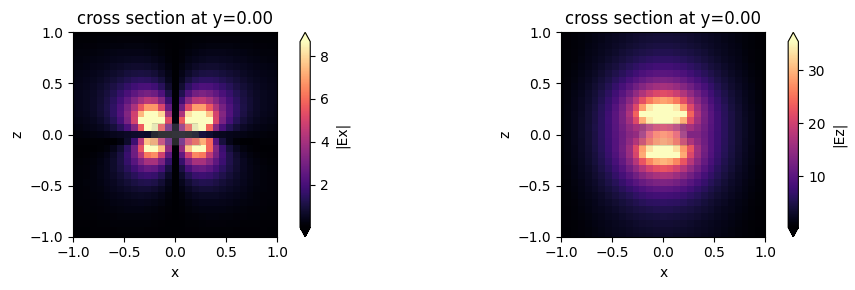

In [8]:
mode_index = 1
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_solver.plot_field("Ex", "abs", mode_index=mode_index, f=freq0, ax=ax1)
mode_solver.plot_field("Ez", "abs", mode_index=mode_index, f=freq0, ax=ax2)
plt.show()


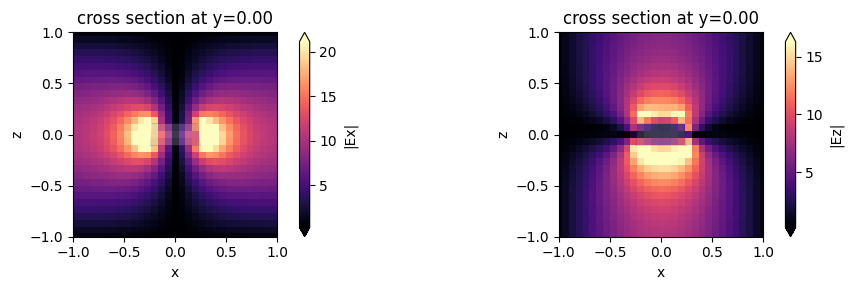

In [9]:
mode_index = 2
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 3))
mode_solver.plot_field("Ex", "abs", mode_index=mode_index, f=freq0, ax=ax1)
mode_solver.plot_field("Ez", "abs", mode_index=mode_index, f=freq0, ax=ax2)
plt.show()
